In [1]:
from neighbor_balance.plotting import get_epigenetics, parse_region, format_ticks
import numpy as np
import matplotlib.pyplot as plt
from neighbor_balance import gtf
from scipy.signal import find_peaks
import pandas as pd


def load_annotations(annotations):
    annotations = gtf.dataframe(annotations)
    # alias = pd.read_csv(alias, sep='\t')
    # alias.rename(columns={'# ucsc': 'ucsc'}, inplace=True)
    # annotations['chrom'] = annotations['seqname'].apply(lambda x: alias.loc[alias['refseq'] == x, 'ucsc'].values[0])
    annotations['start'] = annotations['start'].astype(int)
    annotations['end'] = annotations['end'].astype(int)
    return annotations


def select_transcripts(transcripts, track, cutoff=5, mode='first'):
    if mode == 'first':
        return transcripts[:1]
    elif mode == 'all':
        return transcripts
    elif mode == 'peaks':
        track_values = []
        for transcript in transcripts:
            tss = transcript.exons[0].start if transcript.strand == '+' else transcript.exons[-1].end
            try:
                chrom = transcript.info.seqname
                if not chrom.startswith('chr'):
                    chrom = 'chr' + chrom
                x, y = get_epigenetics(track, chrom, tss-1000, tss+1000)
                track_values += [np.max(y)]
            except Exception as e:
                print(f'Error getting epigenetics for TSS at {tss}: {e}')
                track_values += [0]
        track_values = np.array(track_values)

        if np.all(track_values < cutoff):
            return [transcripts[np.argmax(track_values)]]
        
        used_tss = []
        filtered_transcripts = []
        for transcript, track_value in zip(transcripts, track_values):
            if track_value <= cutoff:
                continue
            tss = transcript.exons[0].start if transcript.strand == '+' else transcript.exons[-1].end
            if np.any(np.isclose(tss, used_tss, atol=5000)):
                continue
            used_tss += [tss]
            filtered_transcripts += [transcript]
        return filtered_transcripts
    else:
        raise ValueError(f'Unknown mode {mode}')


def get_transcripts_in_region(entries, expression, chrom, start, end, track, track_cutoff=1, expression_col='cpm', mode='first'):
    transcripts = []
    expression_values = []
    for gene in entries[chrom]:
        if gene.gene_id in expression.index:
            expression_value = expression.loc[gene.gene_id, expression_col]
        else:
            expression_value = np.nan
        filtered_transcripts = select_transcripts(gene.transcripts, track, cutoff=track_cutoff, mode=mode)
        for transcript in filtered_transcripts:
            tss = transcript.exons[0].start if transcript.strand == '+' else transcript.exons[-1].end
            if start < tss <= end:
                transcripts += [transcript]
                expression_values += [expression_value]
    return transcripts, expression_values


def plot_region(name, expression_col='cpm', remove_chr=False, low_cut=1, high_cut=10, transcript_select_track='POLII S5P', show_inactive=False, max_depth=10, mode='first', track_cutoff=1):
    region = prod[name]['mei'].mei.config['region']
    chrom, start, end = parse_region(region)
    p_loop = np.mean([d.labels == -1 for d in domains[name]], axis=0)

    f, ax = plt.subplots(2 + len(tracks), figsize=(10, (2 + len(tracks)*0.75)), sharex=True, gridspec_kw={'height_ratios': [1] + [0.5]*len(tracks) + [max_depth/10]})
    ax[0].plot(np.arange(start, end, 200), p_loop, color='black')
    ax[0].set_ylim(0, 1)
    ax[0].yaxis.tick_right()
    ax[0].set_ylabel('Protrusion\nProbability')
    ax[0].set_xlim(start, end)

    for i, track_name in enumerate(tracks.keys()):
        x, y = get_epigenetics(tracks[track_name], chrom, start, end)
        ax[i+1].fill_between(x, 0, y, color='steelblue')
        ax[i+1].set_ylabel(track_name)
        ax[i+1].yaxis.tick_right()
        ax[i+1].set_ylim(0, None)
    format_ticks(ax[-1], rotate=False, y=False)

    _chrom = chrom.replace('chr', '') if remove_chr else chrom
    transcripts, expression_values = get_transcripts_in_region(entries, expression,
         _chrom, start, end, tracks[transcript_select_track], expression_col=expression_col, mode=mode, track_cutoff=track_cutoff)
    
    transcript_plot = TranscriptPlot(max_depth=max_depth)
    for transcript, expression_value in zip(transcripts, expression_values):
        ls = '-'
        if np.isnan(expression_value):
            color = 'magenta'
        if expression_value > high_cut:
            color = 'red'
        elif expression_value > low_cut:
            color = 'orange'
        else:
            color = 'gray'
            ls = '--'

        if show_inactive or expression_value > low_cut:
            y = transcript_plot.get_y(transcript)
            transcript.plot(ax[-1], y=-y, h=0.25, color=color, label=False)

        tss = transcript.exons[0].start if transcript.strand == '+' else transcript.exons[-1].end
        for a in ax[:-1]:
            a.axvline(tss, color=color, lw=1, zorder=-1, ls=ls)
    ax[0].set_xlim(start, end)
    ax[-1].set_ylim(-max_depth - 0.5, 1.5)
    return f, ax

class Gene:
    def __init__(self, gene_id, transcripts, info):
        self.gene_id = gene_id
        self.transcripts = transcripts
        self.info = info

class Transcript:
    def __init__(self, transcript_id, strand, exons, info):
        self.transcript_id = transcript_id
        self.strand = strand
        self.exons = exons
        self.info = info

    def plot(self, ax, y=0, h=0.25, w=1000, color='blue', label=True):
        strand = self.strand == '+'
        start, end = self.exons[0].start, self.exons[-1].end
        tss = start if strand else end
        for exon in self.exons:
            ax.plot([exon.start, exon.end], [y, y], color=color, linewidth=5, solid_capstyle="butt",)
        ax.plot([start, end], [y, y], color='k', linewidth=1)
        ax.plot([tss, tss], [y, y+h], color='k', linewidth=1)
        _w = w if strand else -w
        ax.plot([tss, tss+_w], [y+h, y+h], color='k', linewidth=1)
        ax.plot([tss, tss+_w], [y+h, y+h], color='k', linewidth=1)

        if label:
            ax.text(tss, y+h*1.5, self.info.gene_name, ha='center', va='bottom')

    def tss(self):
        return self.exons[0].start if self.strand == '+' else self.exons[-1].end

class Exon:
    def __init__(self, start, end, info):
        self.start = start
        self.end = end
        self.info = info

class TranscriptPlot:
    def __init__(self, max_depth=10, buffer=5000):
        self.entries = []
        self.max_depth = max_depth
        self.buffer = buffer

    def get_y(self, transcript):
        start = transcript.exons[0].start
        end = transcript.exons[-1].end
        occupied = []
        for entry in self.entries:
            if ((start - self.buffer < entry['start'] < end + self.buffer)
                or (start - self.buffer < entry['end'] < end + self.buffer)
                or (entry['start'] < start - self.buffer and entry['end'] > end + self.buffer)):
                occupied += [entry['y']]
        for i in range(self.max_depth):
            if i not in occupied:
                self.entries += [{'start': start, 'end': end, 'y': i}]
                return i
        return i


def process_genes(genes):
    entries = {}
    for gene_id, gene_group in genes.groupby('gene_id'):
        gene_entry = gene_group.loc[gene_group.feature == 'gene']
        transcripts = []
        if len(gene_entry) == 0:
            print(f'No gene entry for {gene_id}')
            continue
        assert len(gene_entry) == 1, gene_group
        for transcript_id, transcript_group in gene_group.groupby('transcript_id'):
            transcript_entry = transcript_group.loc[transcript_group.feature == 'transcript']
            assert len(transcript_entry) == 1
            exons = transcript_group.loc[transcript_group.feature == 'exon']
            assert len(exons) > 0

            exons = [Exon(row.start, row.end, row) for _, row in exons.iterrows()]
            exons = sorted(exons, key=lambda x: x.start)
            transcripts += [Transcript(transcript_id, transcript_entry.iloc[0].strand, exons, transcript_entry.iloc[0])]

        chrom = gene_entry.iloc[0].seqname
        if chrom not in entries:
            entries[chrom] = []
        entries[chrom] += [Gene(gene_id, transcripts, gene_entry.iloc[0])]
    return entries

def metaplot_tss(entries, expression, tracks, domains, prod, low_cut=1, high_cut=10, w=30_000 // 200, regions=None, remove_chr=False, expression_col='cpm', base_name=None, mode='first'):
    p_loop_tss = []
    tracks_tss = {name: [] for name in tracks.keys()}
    all_expression_values = []
    for name in regions:
        region = prod[name]['mei'].mei.config['region']
        chrom, start, end = parse_region(region)
        p_loop = np.mean([d.labels == -1 for d in domains[name]], axis=0)
        track_vals = {track_name: get_epigenetics(tracks[track_name], chrom, start, end)[1] for track_name in tracks.keys()}
        _chrom = chrom.replace('chr', '') if remove_chr else chrom
        transcripts, expression_values = get_transcripts_in_region(entries, expression, _chrom, start, end, tracks['POLII'], track_cutoff=100, expression_col=expression_col, mode=mode)
        for transcript, expression_value in zip(transcripts, expression_values):
            tss = transcript.exons[0].start if transcript.strand == '+' else transcript.exons[-1].end
            if start + 30_000 < tss < end - 30_000:
                all_expression_values += [expression_value]
                index = int((tss - start) / 200)
                p_loop_tss += [p_loop[index-w:index+w+1]]
                if transcript.strand == '-':
                    p_loop_tss[-1] = p_loop_tss[-1][::-1]
                for track_name in tracks.keys():
                    tracks_tss[track_name] += [track_vals[track_name][index-w:index+w+1]]
                    if transcript.strand == '-':
                        tracks_tss[track_name][-1] = tracks_tss[track_name][-1][::-1]

    all_expression_values = np.array(all_expression_values)
    names = ['Protrusion Probability'] + list(tracks.keys())
    for name, windows in zip(names, [p_loop_tss] + list(tracks_tss.values())):
        f, ax = plt.subplots(figsize=(4, 2))
        mask = all_expression_values > high_cut
        plt.plot(np.arange(-w*200, (w+1)*200, 200), np.mean(np.array(windows)[mask], axis=0), color='red', label=f'High n={np.sum(mask)}')
        mask = (all_expression_values > low_cut) & (all_expression_values <= high_cut)
        if np.sum(mask) > 0:
            plt.plot(np.arange(-w*200, (w+1)*200, 200), np.mean(np.array(windows)[mask], axis=0), color='orange', label=f'Medium n={np.sum(mask)}')
        mask = all_expression_values <= low_cut
        plt.plot(np.arange(-w*200, (w+1)*200, 200), np.mean(np.array(windows)[mask], axis=0), color='gray', label=f'Low n={np.sum(mask)}')
        plt.axvline(5000, color='gray', lw=1, ls='--')
        plt.axvline(0, color='gray', lw=1, ls='--')
        plt.axvline(-5000, color='gray', lw=1, ls='--')
        plt.xlabel('Distance from TSS (bp)')
        plt.ylabel(name)
        plt.legend(fontsize=7)
        format_ticks(ax, y=False)
        if base_name:
            plt.savefig(f'{base_name}_{name}.pdf', bbox_inches='tight')
        plt.show()

    for p_loop_window, expression_value in zip(p_loop_tss, all_expression_values):
        color = 'blue' if expression_value > 10 else 'gray'
        plt.plot(np.arange(-w*200, (w+1)*200, 200), p_loop_window, color=color, alpha=0.5)
    plt.xlabel('Distance from TSS (bp)')
    plt.ylabel('Protrusion Probability')
    plt.title('Protrusion Probability around TSS')
    plt.show()

    atac = np.array(tracks_tss['ATAC'])[:, w]
    loop = np.array(p_loop_tss)[:, w]
    plt.scatter(np.log10(atac + 1), loop, c=np.log10(1 + all_expression_values), cmap='viridis', s=5, vmax=1.5)
    plt.colorbar(label='Log10(Expression + 1)')
    plt.xlabel('Log10(ATAC + 1)')
    plt.ylabel('Protrusion Probability')
    plt.show()

In [2]:
import pickle
cache_file = 'data/domains.pkl'
data = pickle.load(open(cache_file, 'rb'))
domains = data['domains']
prod = data['prod']

In [3]:
# Download the GTF file from Ensembl
# wget https://ftp.ensembl.org/pub/release-115/gtf/mus_musculus/Mus_musculus.GRCm39.115.gtf.gz
# gunzip Mus_musculus.GRCm39.115.gtf.gz
annotation_file = '/home/joepaggi/share/ucsc/Mus_musculus.GRCm39.115.gtf'

# Gene expression data from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM3672212
# wget 'https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM3672nnn/GSM3672211/suppl/GSM3672211%5FC59.1%5Fhtseq%5Fcounts.txt.gz' -O GSM3672211_C59.1_htseq_counts.txt.gz
# wget 'https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM3672nnn/GSM3672212/suppl/GSM3672212%5FC59.2%5Fhtseq%5Fcounts.txt.gz' -O GSM3672212_C59.2_htseq_counts.txt.gz
counts_rep1 = 'GSM3672211_C59.1_htseq_counts.txt'
counts_rep2 = 'GSM3672212_C59.2_htseq_counts.txt'

supercloud = '/home/joepaggi/orcd/pool'
tracks = {
    'ATAC': f'{supercloud}/omics/genomics_data/GSE98390_E14_ATAC_MERGED.DANPOS.mm39.bw',
    'POLII': f'{supercloud}/omics/genomics_data/GSM6809981_WT_PolII_xChIP_r2_mm39_MERGED_rmdup_downsampled.bw',
    'RNA-seq': f'{supercloud}/omics/genomics_data/GSE123636_C59_1_2_RNAseq_coverage.mm39.bw',
}

In [4]:
genes = load_annotations(annotation_file)
entries = process_genes(genes)

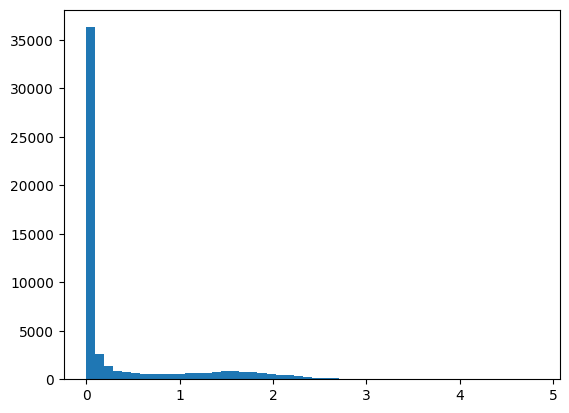

,count_rep1,count_rep2,count,cpm
gene,,,,
ENSMUSG00000000000,0,0,0,0.000000
ENSMUSG00000000001,1694,1733,3427,79.522951
ENSMUSG00000000003,0,0,0,0.000000
ENSMUSG00000000028,2377,2160,4537,105.280312
ENSMUSG00000000031,1367,1105,2472,57.362339
...,...,...,...,...
ENSMUSG00000117336,0,0,0,0.000000
ENSMUSG00000117337,0,0,0,0.000000
ENSMUSG00000117338,0,0,0,0.000000


In [5]:
expression1 = pd.read_csv(counts_rep1, sep='\t', header=None, names=['gene', 'count'])
expression2 = pd.read_csv(counts_rep2, sep='\t', header=None, names=['gene', 'count'])
expression = expression1.merge(expression2, on='gene', suffixes=('_rep1', '_rep2'))
expression['gene'] = expression['gene'].apply(lambda x: x.split('.')[0])  # Remove version number
expression = expression.set_index('gene')
expression['count'] = expression['count_rep1'] + expression['count_rep2']
expression ['cpm'] = expression['count'] / expression['count'].sum() * 1e6
plt.hist(np.log10(expression['cpm'] + 1), bins=50)
plt.show()
expression

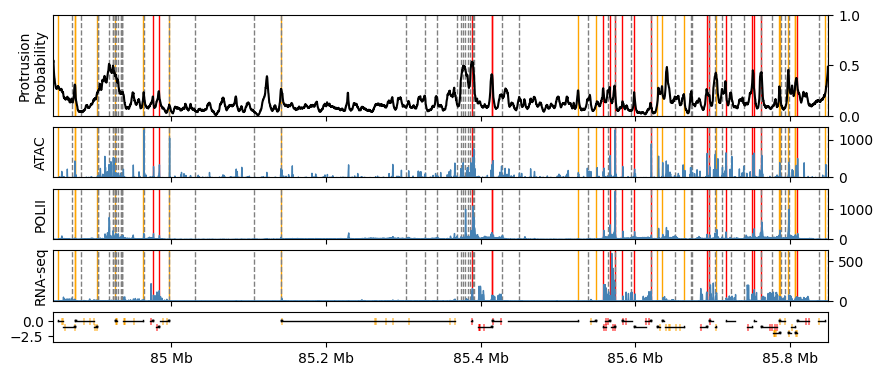

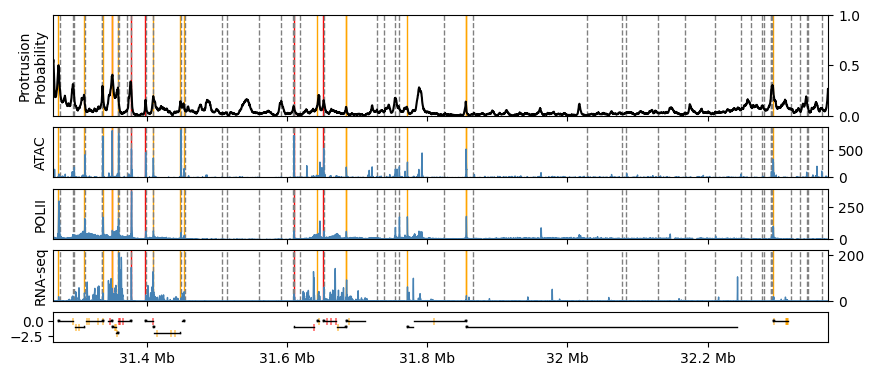

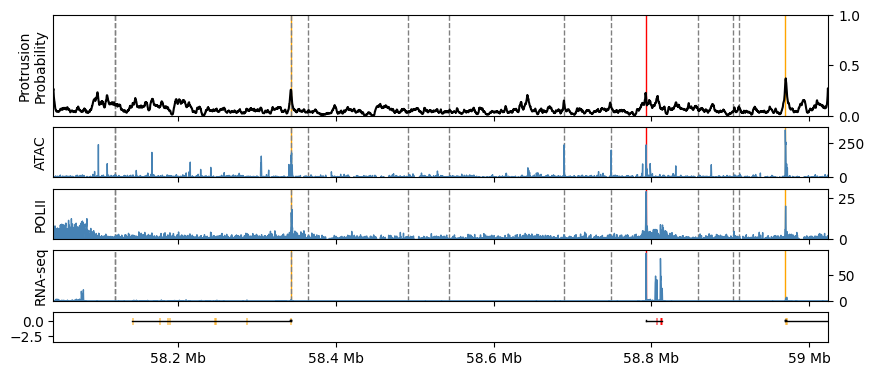

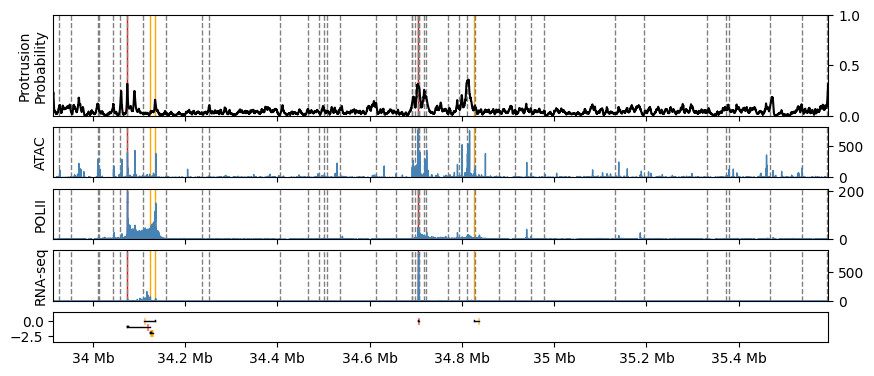

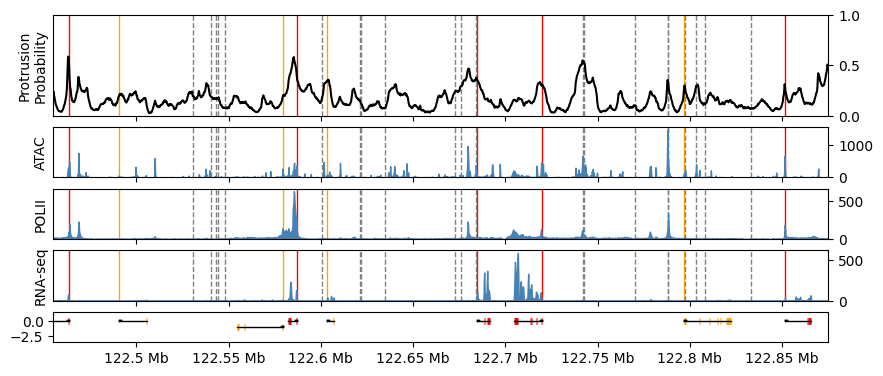

In [6]:
high_cut = 50
low_cut = 1

for name in ['klf1', 'ppm1g', 'fbn2', 'sox2', 'nanog']:
    plot_region(name, high_cut=high_cut, low_cut=low_cut, remove_chr=True, transcript_select_track='POLII', max_depth=3, mode='first')
    plt.show()

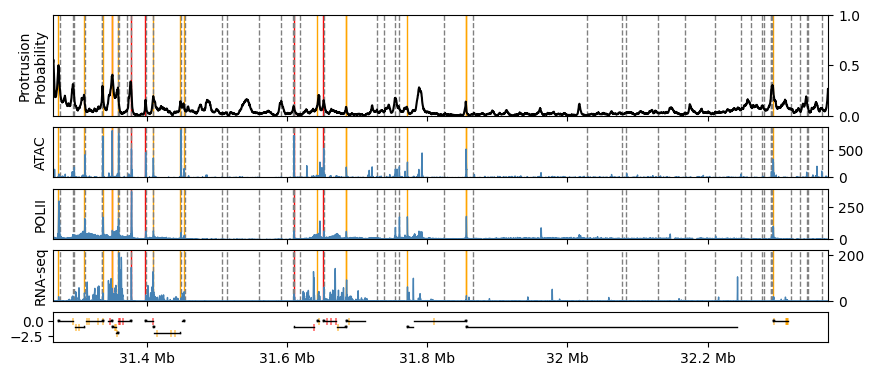

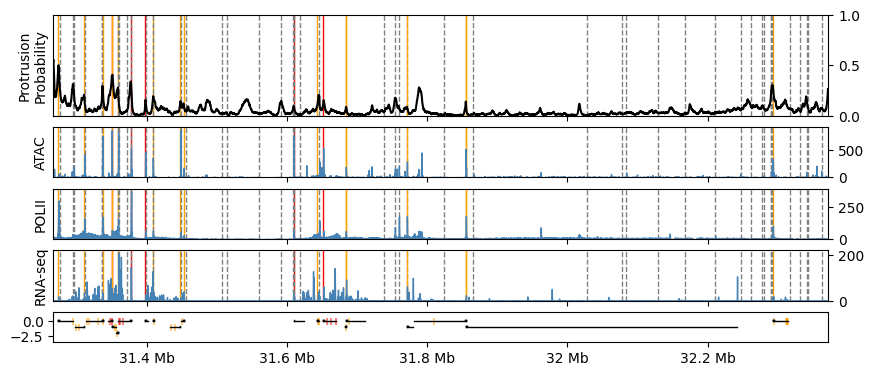

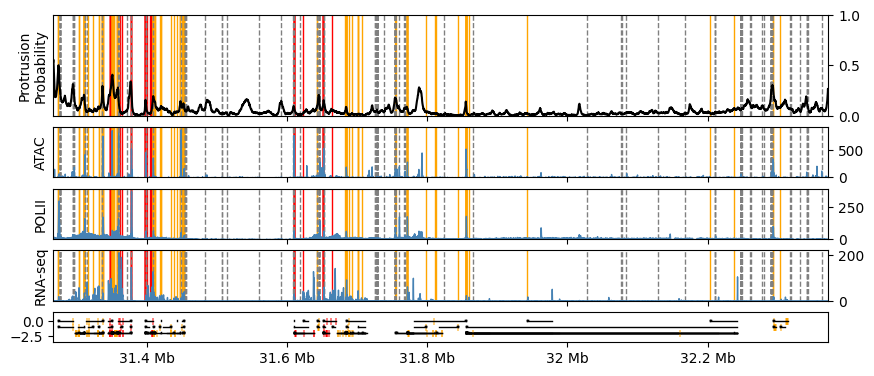

In [7]:
name = 'ppm1g'
for mode in ['first', 'peaks', 'all']:
    plot_region(name, high_cut=high_cut, low_cut=low_cut, remove_chr=True, transcript_select_track='POLII', max_depth=3, mode=mode, track_cutoff=100)
    plt.show()

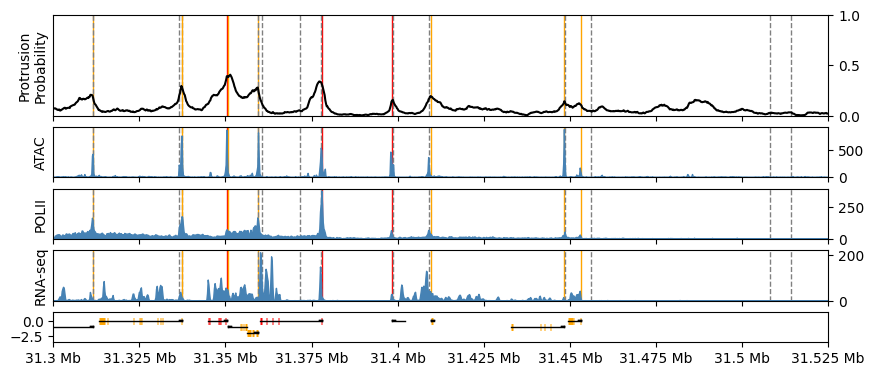

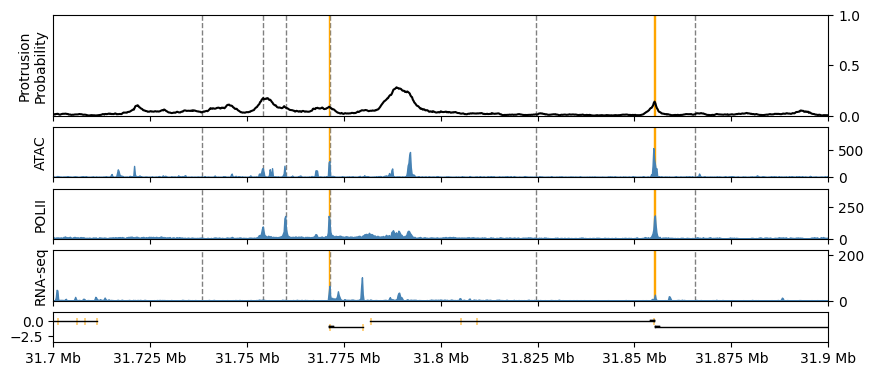

In [8]:
f, ax = plot_region('ppm1g', high_cut=high_cut, low_cut=low_cut, remove_chr=True, transcript_select_track='POLII', max_depth=3, mode='peaks', track_cutoff=100)
ax[0].set_xlim(31.3e6, 31.525e6)
plt.show()

f, ax = plot_region('ppm1g', high_cut=high_cut, low_cut=low_cut, remove_chr=True, transcript_select_track='POLII', max_depth=3, mode='peaks', track_cutoff=100)
ax[0].set_xlim(31.7e6, 31.9e6)
plt.show()

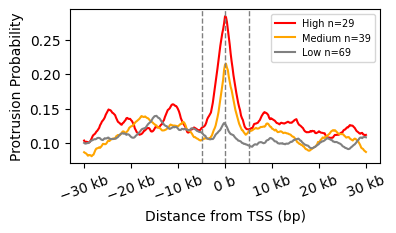

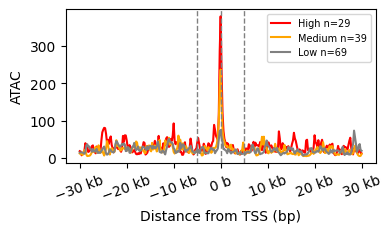

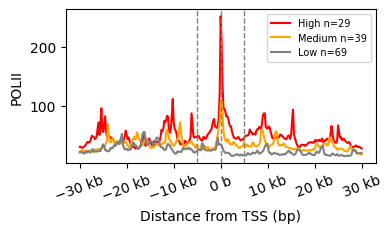

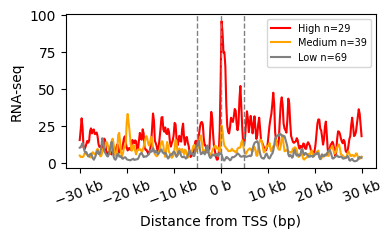

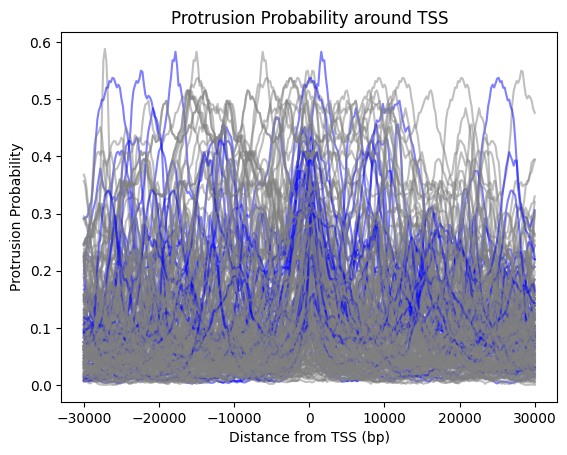

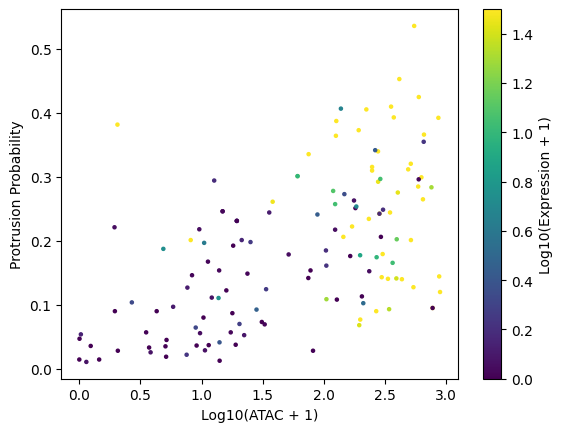

In [9]:
metaplot_tss(entries, expression, tracks, domains, prod, low_cut=low_cut, high_cut=high_cut, regions=['nanog', 'klf1', 'ppm1g', 'fbn2', 'sox2'], remove_chr=True, base_name='img/transcription_aggregrate_mescs')

# HCT116

In [10]:
"""
wget 'https://www.encodeproject.org/files/ENCFF159KBI/@@download/ENCFF159KBI.gtf.gz' -O ENCFF159KBI.gtf.gz
gunzip ENCFF159KBI.gtf.gz
wget 'https://www.encodeproject.org/files/ENCFF435PHM/@@download/ENCFF435PHM.tsv' -O ENCFF435PHM.tsv

wget 'https://www.encodeproject.org/files/ENCFF855XPI/@@download/ENCFF855XPI.bigWig' -O ENCFF855XPI.bigWig
wget 'https://www.encodeproject.org/files/ENCFF802CGI/@@download/ENCFF802CGI.bigWig' -O ENCFF802CGI.bigWig

wget 'https://www.encodeproject.org/files/ENCFF087ORU/@@download/ENCFF087ORU.bigWig' -O ENCFF087ORU.bigWig
wget 'https://www.encodeproject.org/files/ENCFF870WXZ/@@download/ENCFF870WXZ.bigWig' -O ENCFF870WXZ.bigWig
"""

annotation_file = 'data/ENCFF159KBI.gtf'
expression = 'data/ENCFF435PHM.tsv'
tracks = {
    'ATAC': '/orcd/data/binz/001/belong/for_revisions/genomics_data/HCT116/ENCFF624HRW.bigWig',
    'POLII S5P': 'data/ENCFF855XPI.bigWig',
    'POLII': 'data/ENCFF802CGI.bigWig',
    'RNA (+)': 'data/ENCFF087ORU.bigWig',
    'RNA (-)': 'data/ENCFF870WXZ.bigWig',
    'H3K27ac': '/orcd/data/binz/001/belong/for_revisions/genomics_data/HCT116/ENCFF758DHJ.bigWig',
    'H3K4me3': '/orcd/data/binz/001/belong/for_revisions/genomics_data/HCT116/ENCFF983JLZ.bigWig',
    'H3K27me3': '/orcd/data/binz/001/belong/for_revisions/genomics_data/HCT116/ENCFF232QSG.bigWig',
    'H3K9me3': '/orcd/data/binz/001/belong/for_revisions/genomics_data/HCT116/ENCFF020CHJ.bigWig',
}

In [11]:
genes = load_annotations(annotation_file)
entries = process_genes(genes)

No gene entry for 10904
No gene entry for 12954
No gene entry for 12956
No gene entry for 12958
No gene entry for 12960
No gene entry for 12962
No gene entry for 12964
No gene entry for 12965
No gene entry for 12967
No gene entry for 12969
No gene entry for 12971
No gene entry for 12973
No gene entry for 12975
No gene entry for 12977
No gene entry for 12979
No gene entry for 12981
No gene entry for 12983
No gene entry for 12985
No gene entry for 12987
No gene entry for 12989
No gene entry for 12991
No gene entry for 12993
No gene entry for 12995
No gene entry for 12997
No gene entry for 12999
No gene entry for 13001
No gene entry for 13003
No gene entry for 13004
No gene entry for 13005
No gene entry for 13006
No gene entry for 13007
No gene entry for 13008
No gene entry for 13009
No gene entry for 13010
No gene entry for 13011
No gene entry for 13012
No gene entry for 13013
No gene entry for 13014
No gene entry for 13015
No gene entry for 13016
No gene entry for 13017
No gene entry fo

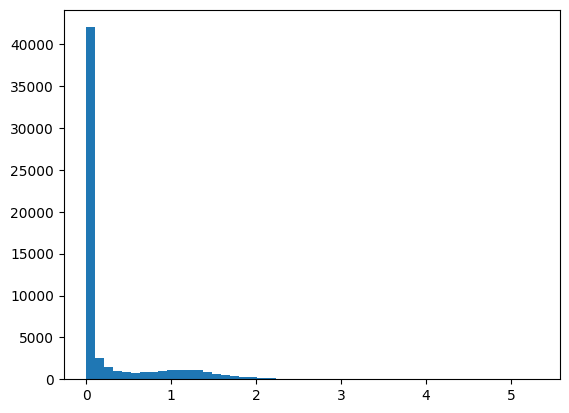

59526 59526


,transcript_id(s),length,effective_length,expected_count,TPM,FPKM,posterior_mean_count,posterior_standard_deviation_of_count,pme_TPM,pme_FPKM,TPM_ci_lower_bound,TPM_ci_upper_bound,TPM_coefficient_of_quartile_variation,FPKM_ci_lower_bound,FPKM_ci_upper_bound,FPKM_coefficient_of_quartile_variation
gene_id,,,,,,,,,,,,,,,,
10904,10904,93.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000
12954,12954,94.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000
12956,12956,72.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000
12958,12958,82.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000
12960,12960,73.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gSpikein_ERCC-00165,tSpikein_ERCC-00165,872.0,773.0,176.0,6.50,7.78,176.0,0.0,6.31,7.77,5.390290e+00,7.229180,0.050479,6.644510e+00,8.908310,0.050480
gSpikein_ERCC-00168,tSpikein_ERCC-00168,1024.0,925.0,2.0,0.06,0.07,2.0,0.0,0.09,0.11,1.072330e-02,0.193829,0.387665,1.318960e-02,0.238578,0.387768
gSpikein_ERCC-00170,tSpikein_ERCC-00170,1023.0,924.0,39.0,1.20,1.44,39.0,0.0,1.19,1.47,8.301520e-01,1.563930,0.106805,1.021570e+00,1.924930,0.106889


In [12]:
expression = pd.read_csv(expression, sep='\t')
expression = expression.set_index('gene_id')
plt.hist(np.log10(expression['TPM'] + 1), bins=50)
plt.show()
print(len(expression.index.unique()), len(expression))
expression

In [13]:
cache_file = 'data/domains_hct116.pkl'
data = pickle.load(open(cache_file, 'rb'))
domains = data['domains']
prod = data['prod']

High cut: 2, Low cut: 2


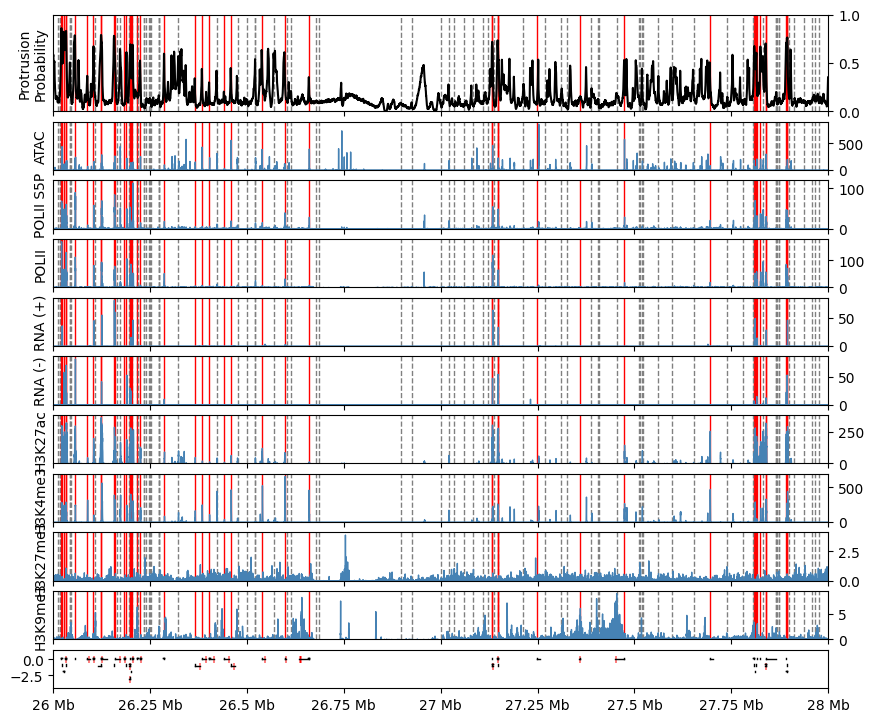

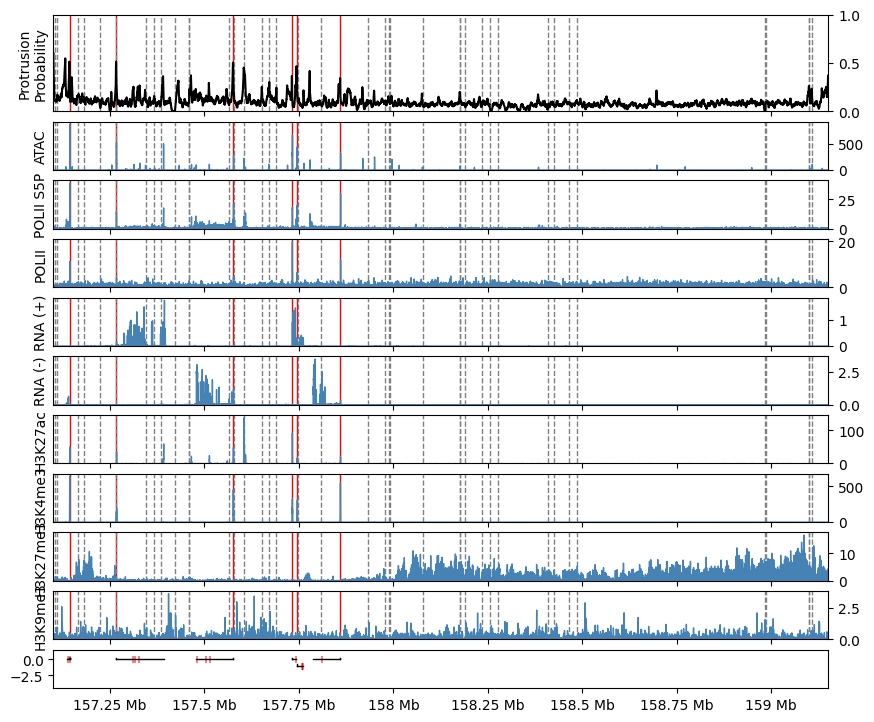

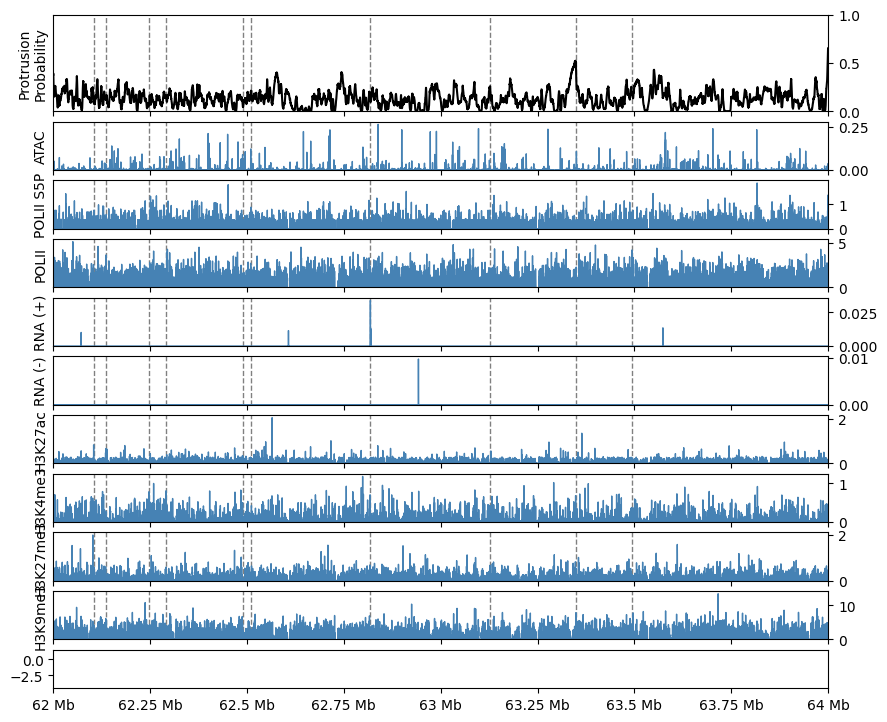

In [14]:
expression_col = 'TPM'
high_cut = 2
low_cut = 2
print(f'High cut: {high_cut}, Low cut: {low_cut}')

for name in ['region1', 'region3', 'region5']:
    plot_region(name, expression_col=expression_col, high_cut=high_cut, low_cut=low_cut, max_depth=4)
    plt.show()

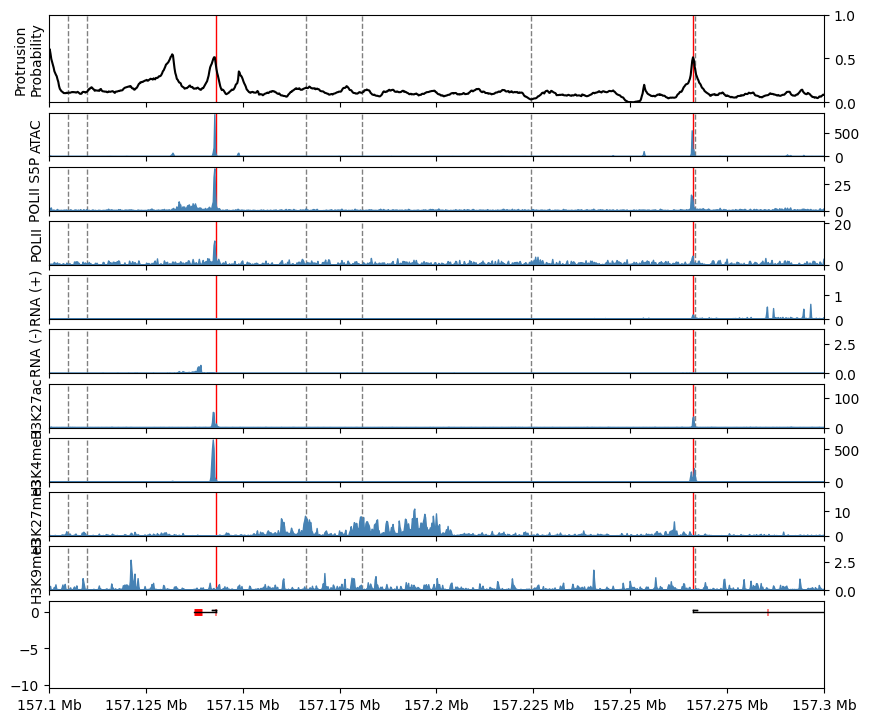

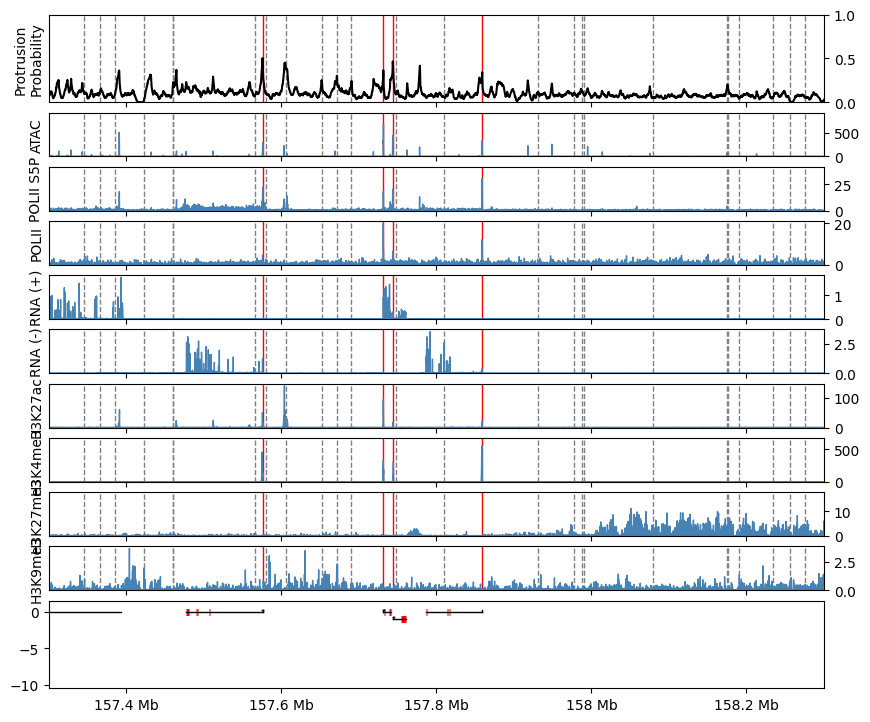

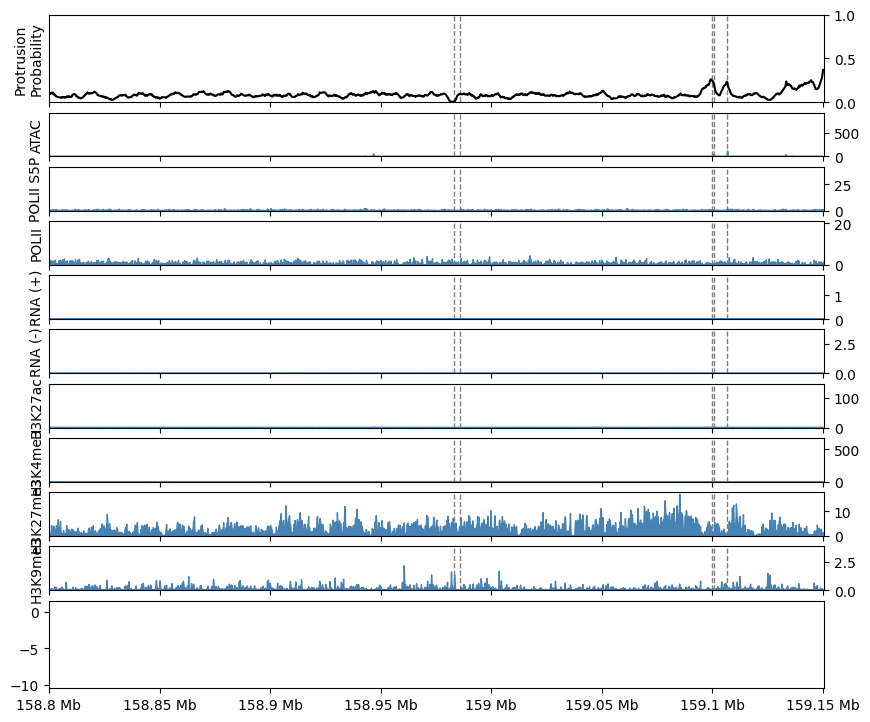

In [15]:
f, ax = plot_region('region3', expression_col=expression_col, high_cut=high_cut, low_cut=low_cut)
ax[0].set_xlim(157.1e6, 157.3e6)
plt.show()

f, ax = plot_region('region3', expression_col=expression_col, high_cut=high_cut, low_cut=low_cut)
ax[0].set_xlim(157.3e6, 158.3e6)
plt.show()

f, ax = plot_region('region3', expression_col=expression_col, high_cut=high_cut, low_cut=low_cut)
ax[0].set_xlim(158.8e6)
plt.show()

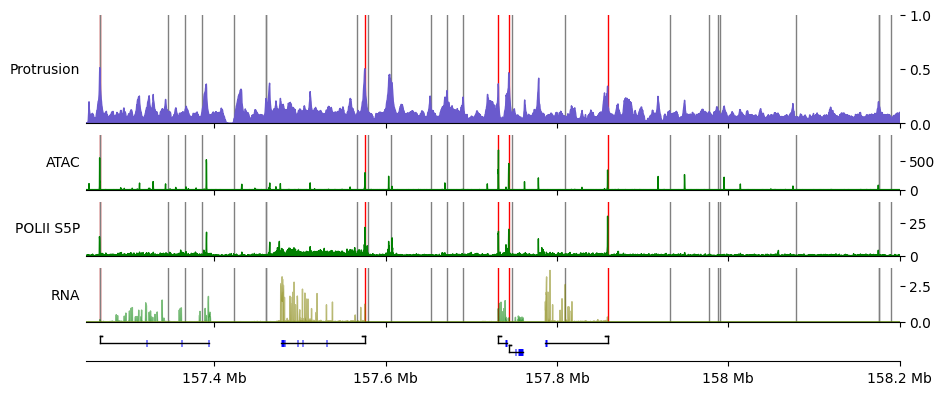

In [16]:
name = 'region3'
region = prod[name]['mei'].mei.config['region']
chrom, start, end = parse_region(region)
p_loop = np.mean([d.labels == -1 for d in domains[name]], axis=0)

f, ax = plt.subplots(5, figsize=(7*1.5, 3*1.5), sharex=True, gridspec_kw={'height_ratios': [2, 1, 1, 1, 0.5]})
ax[0].fill_between(np.arange(start, end, 200), 0, p_loop, color='slateblue')
ax[0].set_ylim(0, 1)
ax[0].yaxis.tick_right()
ax[0].set_ylabel('Protrusion', rotation=0, ha='right', va='center')
ax[0].set_xlim(start, end)

for i, track_name in enumerate(['ATAC', 'POLII S5P']):
    x, y = get_epigenetics(tracks[track_name], chrom, start, end)
    ax[i+1].fill_between(x, 0, y, color='green')
    ax[i+1].set_ylabel(track_name, rotation=0, ha='right', va='center')
    ax[i+1].yaxis.tick_right()
    ax[i+1].set_ylim(0, None)

i = i + 2
x, y = get_epigenetics(tracks['RNA (+)'], chrom, start, end)
ax[i].fill_between(x, 0, y, color='green', alpha=0.5)
x, y = get_epigenetics(tracks['RNA (-)'], chrom, start, end)
ax[i].fill_between(x, 0, y, color='olive', alpha=0.5)
ax[i].set_ylabel('RNA', rotation=0, ha='right', va='center')
ax[i].yaxis.tick_right()
ax[i].set_ylim(0, None)


format_ticks(ax[-1], rotate=False, y=False)

transcripts, expression_values = get_transcripts_in_region(entries, expression, chrom, start, end, tracks['POLII S5P'], expression_col=expression_col, track_cutoff=3, mode='first')
transcript_plot = TranscriptPlot(max_depth=3)
for transcript, expression_value in zip(transcripts, expression_values):
    if np.isnan(expression_value):
        color = 'magenta'
    if expression_value > high_cut:
        color = 'red'
    elif expression_value > low_cut:
        color = 'orange'
    else:
        color = 'gray'
    #plot_transcript(transcript, ax[-1], y=i, color=color, h=0.75, w=3000, label=False)

    if expression_value > low_cut:
        y = transcript_plot.get_y(transcript)
        transcript.plot(ax[-1], y=-y, color='blue', h=0.75, w=3000, label=False)
    tss = transcript.exons[0].start if transcript.strand == '+' else transcript.exons[-1].end
    for a in ax[:-1]:
        a.axvline(tss, color=color, lw=1, zorder=-1)
ax[-1].set_yticks([])
ax[-1].set_ylim(-2, 1)
for a in ax:
    a.spines[['top', 'left', 'right']].set_visible(False)
ax[0].set_xlim(157.25e6, 158.2e6)
plt.savefig('img/transcription_region3_zoom.pdf')
plt.show()

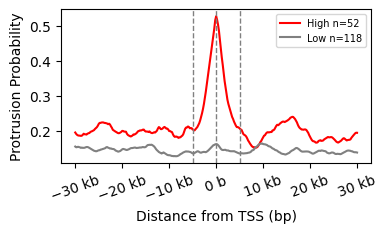

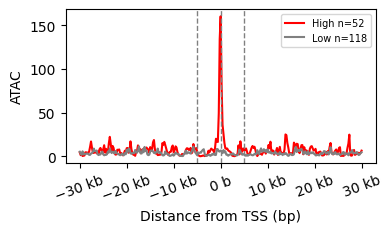

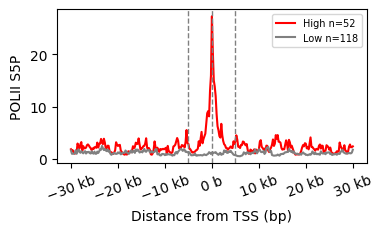

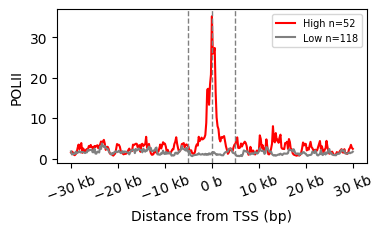

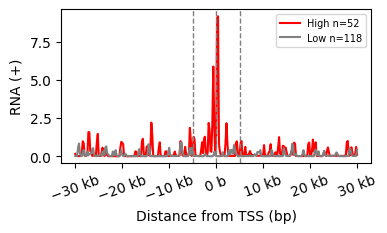

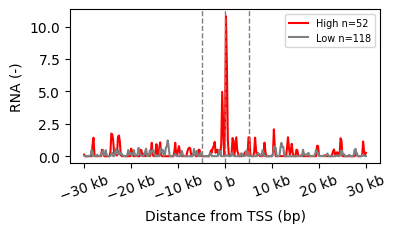

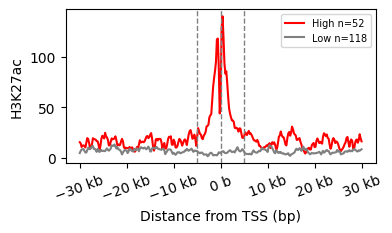

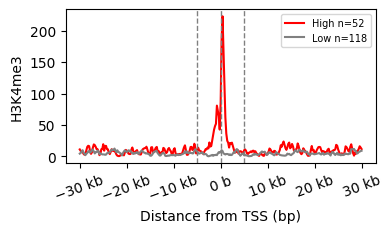

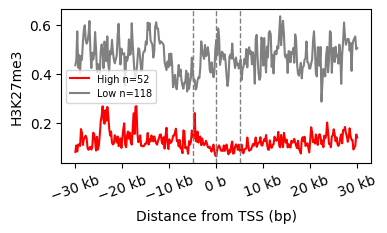

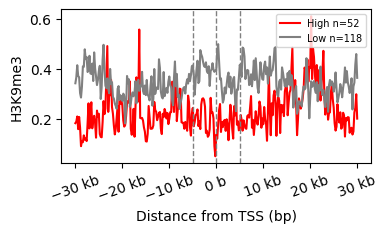

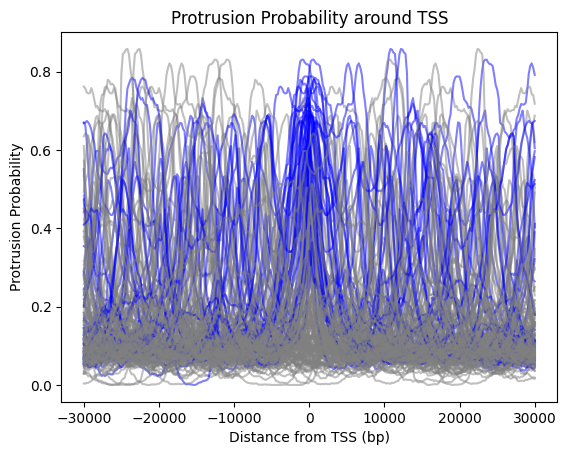

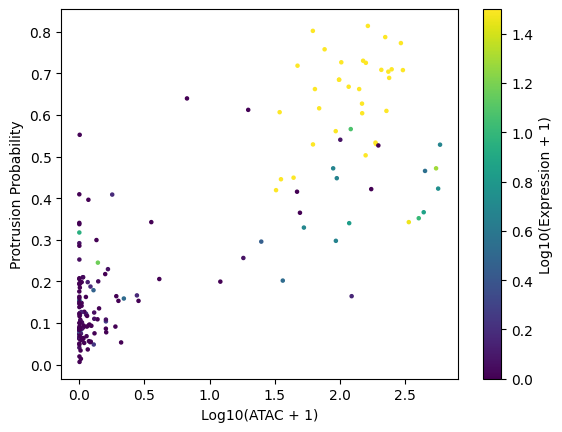

In [18]:
metaplot_tss(entries, expression, tracks, domains, prod, low_cut=low_cut, high_cut=high_cut, regions=['region1', 'region3', 'region5'], expression_col=expression_col, base_name='img/transcription_aggregrate_hct116', mode='first')